In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from scipy import stats

Initialize Spark

In [2]:
spark = SparkSession.builder \
    .appName("EcommerceAnalysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.local.dir", "I:/spark_temp") \
    .getOrCreate()

In [3]:
# Load data
df = spark.read.csv('../data/raw/2019-Oct.csv', header=True, inferSchema=True)

## Basic Cleaning

After our initial exploration, we've identified several data quality issues that need addressing.
Below we implement our cleaning steps sequentially, explaining each decision.

### Duplicate Removal

First, we'll remove exact duplicates within user session from our dataset. In the context of a recommendation system,
duplicate records of the same event don't provide additional information about user preferences
and could potentially skew our understanding of user behavior.

In [ ]:
df = df.dropDuplicates(['event_type', 'product_id', 'category_id', 'category_code', 
                        'brand', 'price', 'user_id', 'user_session'])
print(f"After removing duplicates, our dataset contains {df.count():,} records")

### Price Filtering

Next, we address price-related issues. Negative or zero prices likely represent data errors or free items
rather than actual product prices. For our model, we want to ensure we're
working with valid price points that reflect real shopping behavior.

In [4]:
df = df.filter(df.price > 0)
print(f"After price filtering, our dataset contains {df.count():,} records")

### Handling Missing Values

For categories where we have the ID but no code, we'll create custom category codes to preserve
the relationships between products in the same category. For missing brands, where we have no
alternative identifier, we'll mark them as 'unknown'.

In [ ]:
# Handle missing category codes
df = df.withColumn('category_code',
    F.when(F.col('category_code').isNull(),
        F.concat(F.lit('custom_category_'), F.col('category_id').cast('string'))
    ).otherwise(F.col('category_code')))

# Handle missing brands
df = df.withColumn('brand', 
    F.when(F.col('brand').isNull(), 'unknown')
    .otherwise(F.col('brand')))

## User Behavior Analysis

In [5]:
# User activity metrics
user_behavior = df.groupBy("user_id").agg(
    F.count("event_type").alias("total_events"),
    F.countDistinct("product_id").alias("unique_products"),
    F.countDistinct("category_id").alias("unique_categories"),
    F.countDistinct("brand").alias("unique_brands"),
    F.countDistinct("user_session").alias("unique_sessions"),
    F.max("price").alias("max_price"),
    F.min("price").alias("min_price"),
    F.avg("price").alias("avg_price"),
    F.datediff(F.max("event_time"), F.min("event_time")).alias("activity_span")
)

In [6]:
# Convert to pandas for visualization (small aggregated dataset)
user_behavior_pd = user_behavior.toPandas()

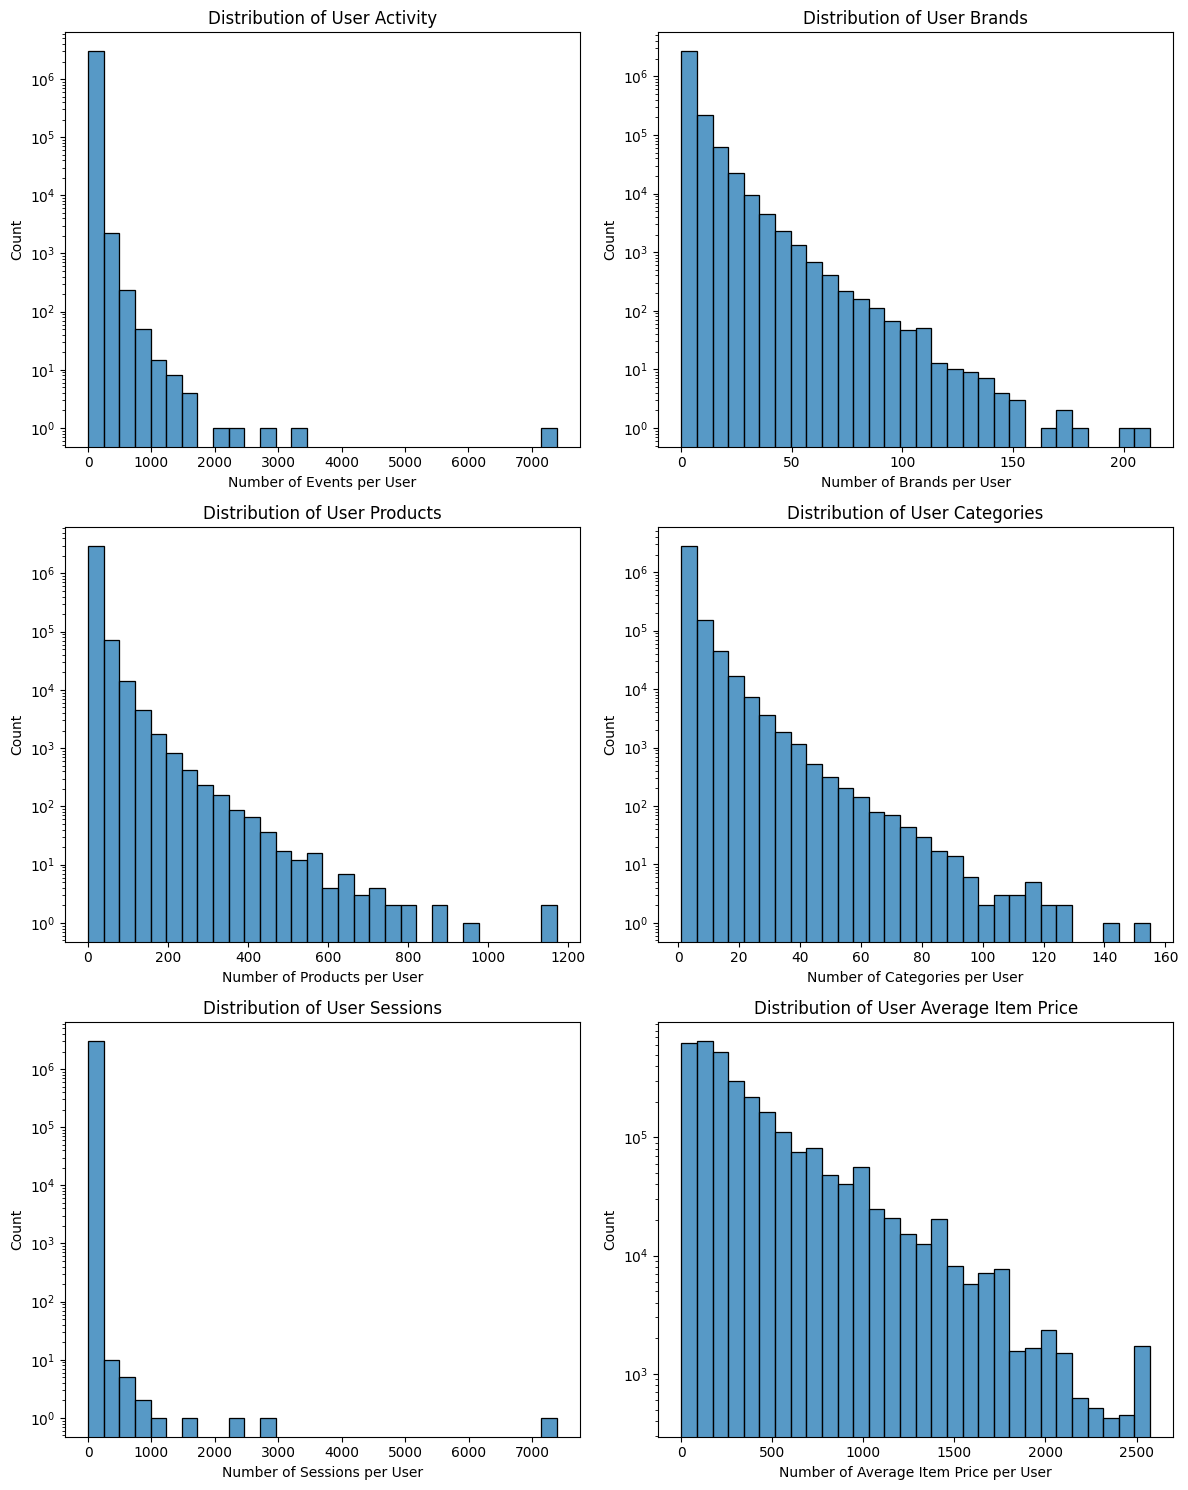

In [7]:
# Create a grid of plots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
plt.subplots_adjust(hspace=0.4)  # Add space between rows

# Flatten axes array for easier iteration if needed
axes = axes.flatten()

# Plot 1: User Activity
sns.histplot(data=user_behavior_pd, x='total_events', bins=30, ax=axes[0])
axes[0].set_title('Distribution of User Activity')
axes[0].set_xlabel('Number of Events per User')
axes[0].set_yscale('log')

# Plot 2: User Brands
sns.histplot(data=user_behavior_pd, x='unique_brands', bins=30, ax=axes[1])
axes[1].set_title('Distribution of User Brands')
axes[1].set_xlabel('Number of Brands per User')
axes[1].set_yscale('log')

# Plot 3: User Products
sns.histplot(data=user_behavior_pd, x='unique_products', bins=30, ax=axes[2])
axes[2].set_title('Distribution of User Products')
axes[2].set_xlabel('Number of Products per User')
axes[2].set_yscale('log')

# Plot 4: User Categories
sns.histplot(data=user_behavior_pd, x='unique_categories', bins=30, ax=axes[3])
axes[3].set_title('Distribution of User Categories')
axes[3].set_xlabel('Number of Categories per User')
axes[3].set_yscale('log')

# Plot 5: User Sessions
sns.histplot(data=user_behavior_pd, x='unique_sessions', bins=30, ax=axes[4])
axes[4].set_title('Distribution of User Sessions')
axes[4].set_xlabel('Number of Sessions per User')
axes[4].set_yscale('log')

# Plot 6: User Average Price
sns.histplot(data=user_behavior_pd, x='avg_price', bins=30, ax=axes[5])
axes[5].set_title('Distribution of User Average Item Price')
axes[5].set_xlabel('Number of Average Item Price per User')
axes[5].set_yscale('log')


plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Text(0.7, 0.92, 'Spearman correlation: 0.102')

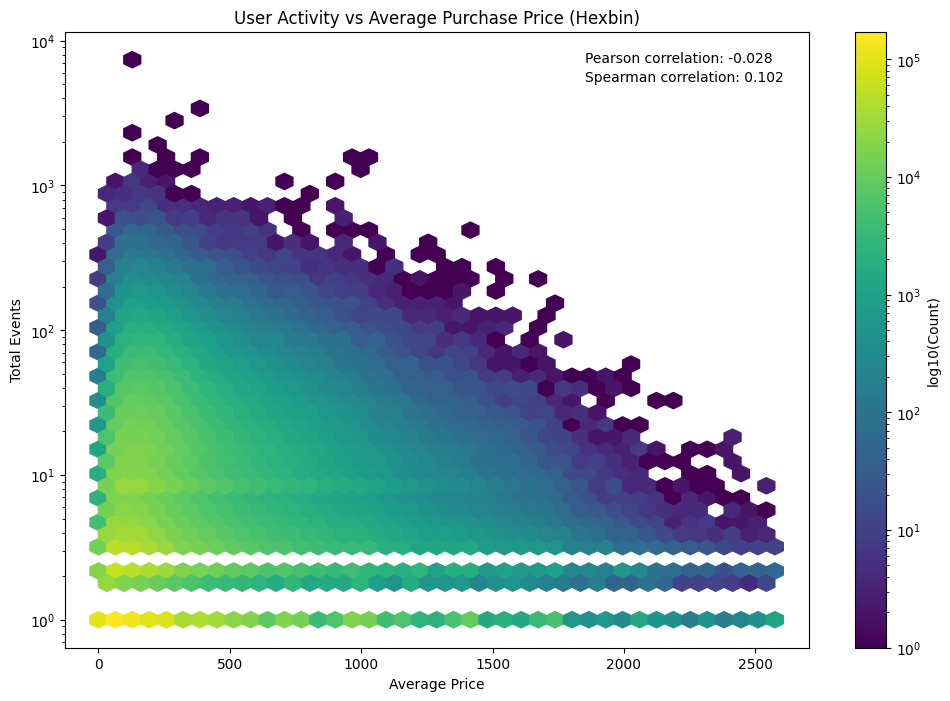

In [8]:
# Price Range Analysis by User
plt.figure(figsize=(12, 8))
plt.hexbin(user_behavior_pd['avg_price'], 
           user_behavior_pd['total_events'],
           gridsize=40,
           bins='log', 
           yscale='log',         
           cmap='viridis',
           mincnt=1)             
plt.colorbar(label='log10(Count)')
plt.title('User Activity vs Average Purchase Price (Hexbin)')
plt.xlabel('Average Price')
plt.ylabel('Total Events')

# Let's also add some statistical context
correlation_pearson = user_behavior_pd['avg_price'].corr(user_behavior_pd['total_events'])
correlation_spearman = stats.spearmanr(user_behavior_pd['avg_price'], user_behavior_pd['total_events']).correlation
plt.text(0.7, 0.95, f'Pearson correlation: {correlation_pearson:.3f}', 
         transform=plt.gca().transAxes)
plt.text(0.7, 0.92, f'Spearman correlation: {correlation_spearman:.3f}', 
         transform=plt.gca().transAxes)

The visualization reveals three key patterns in our e-commerce data. Despite an apparent negative trend, the correlation coefficient (-0.028) shows an extremely weak relationship between price and activity. Most user activity concentrates in the lower price range (0-500), shown by the bright yellow-green area. We can observe three distinct horizontal bands at the bottom of the plot representing users with exactly 1, 2, or 3 events, indicating a significant number of one-time or occasional shoppers across all price ranges. While activity generally decreases with higher prices (seen in the darker purple hexagons), there exist highly active users even in higher price ranges, suggesting diverse shopping behaviors that aren't strongly tied to price points.

Text(0.05, 0.84, 'Spearman correlation: 0.682')

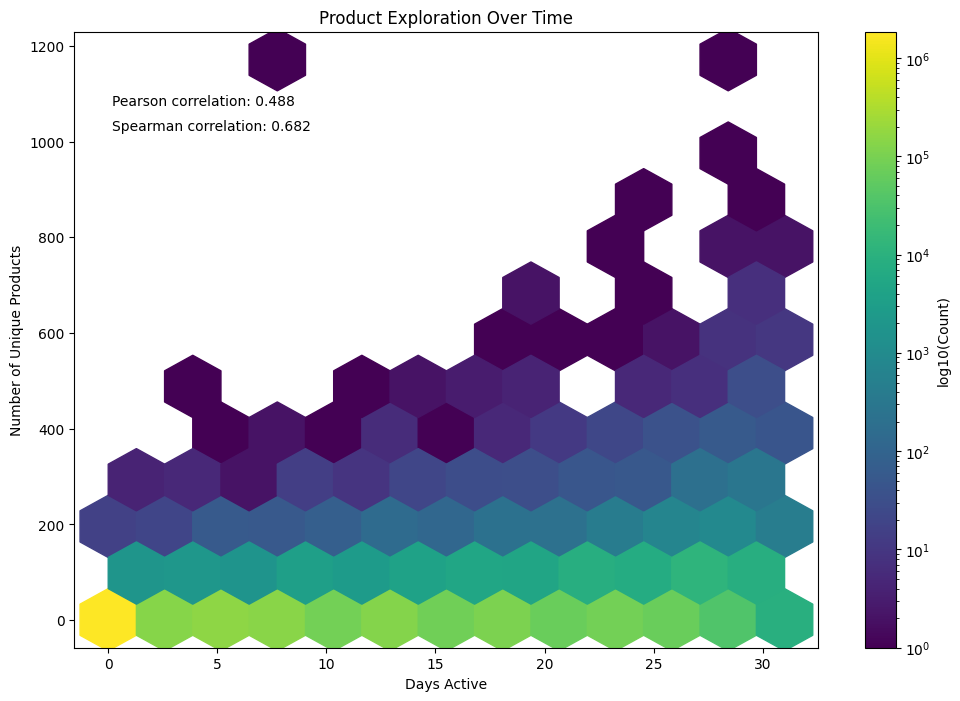

In [9]:
# Activity Span vs Engagement:
plt.figure(figsize=(12, 8))
plt.hexbin(user_behavior_pd['activity_span'], 
               user_behavior_pd['unique_products'],
           gridsize=12,
           bins='log',
           cmap='viridis',)
plt.colorbar(label='log10(Count)')

# Add title and labels
plt.title('Product Exploration Over Time')
plt.xlabel('Days Active')
plt.ylabel('Number of Unique Products')

# Add correlation coefficient for context
correlation_pearson = user_behavior_pd['activity_span'].corr(user_behavior_pd['unique_products'])
correlation_spearman = stats.spearmanr(user_behavior_pd['activity_span'], user_behavior_pd['unique_products']).correlation
plt.text(0.05, 0.88, f'Pearson correlation: {correlation_pearson:.3f}', 
         transform=plt.gca().transAxes)
plt.text(0.05, 0.84, f'Spearman correlation: {correlation_spearman:.3f}', 
         transform=plt.gca().transAxes)


The visualization shows a moderate positive correlation between users active days and the number of unique products they explore. Most users, represented by the yellow-green area at the bottom, interact with a limited number of products (0-100) regardless of their time on the platform. However, we observe a distinct pattern where some users significantly increase their product exploration after 15-20 days of activity, shown by the upward trend in darker hexagons. The scattered purple hexagons at the top (reaching 1200 products) represent highly engaged users who explore an exceptionally diverse range of items. This insight suggests that user tenure should be a significant factor in our recommendation strategy, with particular attention paid to the critical 15-20 day period where some users begin to expand their product exploration significantly.

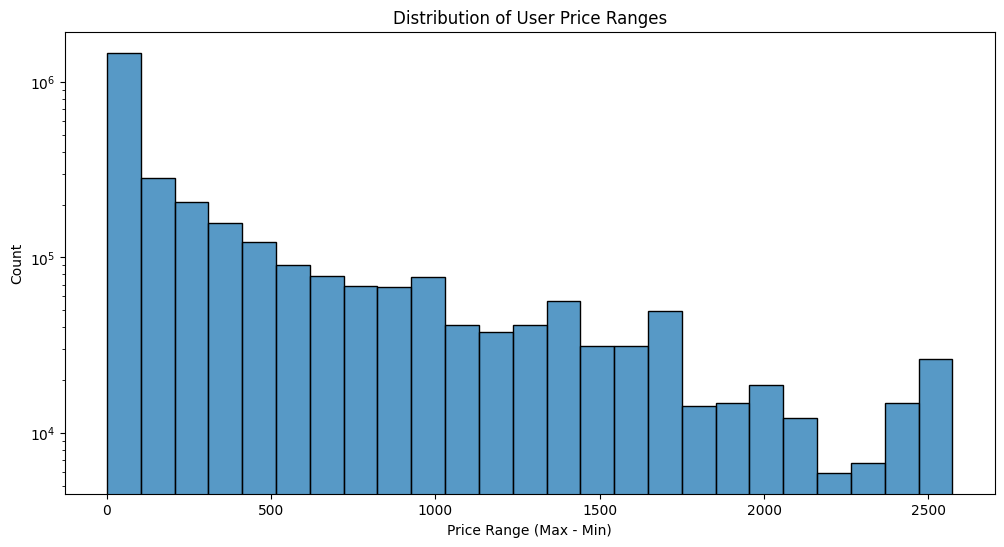

In [10]:
# Calculate price range for each user
user_behavior_pd = user_behavior_pd[user_behavior_pd['min_price'] > 0]
user_behavior_pd['price_range'] = user_behavior_pd['max_price'] - user_behavior_pd['min_price']


plt.figure(figsize=(12, 6))
sns.histplot(data=user_behavior_pd, x='price_range', bins=25)
plt.title('Distribution of User Price Ranges')
plt.xlabel('Price Range (Max - Min)')
plt.yscale('log')

The Distribution of User Price Ranges histogram reveals that most users operate within a narrow price range (under 500 units), as shown by the tallest bars on the left. This indicates that typical users have consistent price preferences and tend to stay within their comfort zone. However, the long tail extending to 2500 units shows that some users are comfortable shopping across a wide price range, from budget to premium items. For our recommendation system, this suggests we should primarily recommend products within a user's established price range while occasionally testing slightly broader ranges to explore potential expansion opportunities.

In [11]:
zero_prices = user_behavior_pd['min_price'] == 0
print(f"{np.sum(zero_prices):,} users with a minimum price equal to 0 from {len(zero_prices):,} users")

0 users with a minimum price equal to 0 from 3,021,435 users


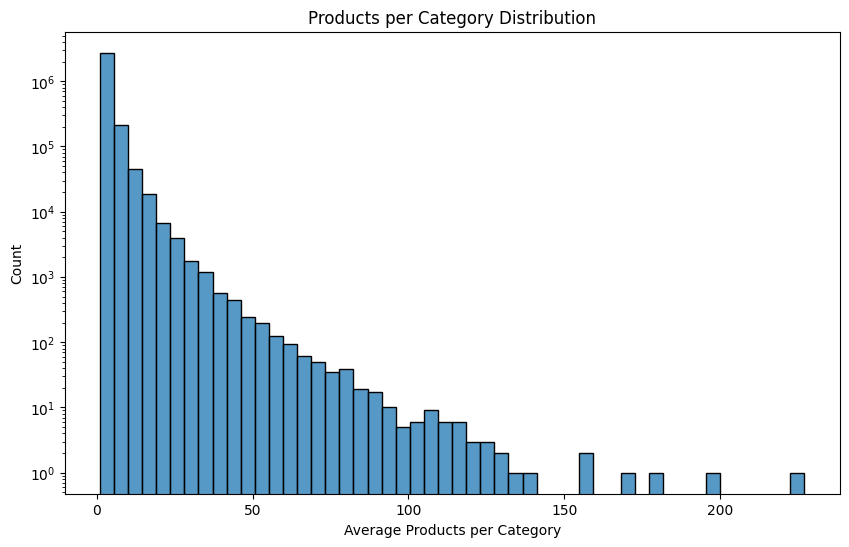

In [12]:
# Product Diversity Ratio
user_behavior_pd['product_category_ratio'] = user_behavior_pd['unique_products'] / user_behavior_pd['unique_categories']

plt.figure(figsize=(10, 6))
sns.histplot(data=user_behavior_pd, x='product_category_ratio', bins=50)
plt.title('Products per Category Distribution')
plt.xlabel('Average Products per Category')
plt.yscale('log')

This distribution reveals the browsing patterns of users within product categories. The logarithmic scale distribution shows that most users explore only a small number of products per category (1-10 items), indicating focused shopping behavior. The long tail extending to 200+ products represents a small group of highly engaged users who extensively explore category offerings.

This insight is valuable for our recommendation system design:
1. Most users need quick, targeted recommendations due to their focused browsing habits
2. A smaller segment requires support for extensive product comparison
3. The system should adapt its recommendation strategy based on user exploration patterns

The extreme long-tail nature of this distribution aligns with typical e-commerce behavior patterns, where most users have specific shopping goals while a minority engage in extensive product research.

In [13]:
# Get statistics about user behavior
user_behavior.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+
|summary|            user_id|      total_events|   unique_products| unique_categories|     unique_brands|   unique_sessions|        max_price|         min_price|        avg_price|    activity_span|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+
|  count|            3021435|           3021435|           3021435|           3021435|           3021435|           3021435|          3021435|           3021435|          3021435|          3021435|
|   mean|5.404668328584484E8|  9.62723076948536| 7.699482530651826| 2.566809810570143|3.3685639439537836|3.0580671104955095|577.3501683505366|191.27610197141956|317.5062042723337|5.261338072803155|
| stddev|1

## Event Analysis


In [14]:
# Event type distribution
event_analysis = df.groupBy("event_type").agg(
    F.count("*").alias("total_events"),
    F.countDistinct("user_id").alias("unique_users"),
    F.countDistinct("product_id").alias("unique_products"),
    F.mean("price").alias("average_price")
)

In [ ]:
event_pd = event_analysis.toPandas()


In [33]:
# Calculate percentages
event_pd['event_percentage'] = (event_pd['total_events'] / event_pd['total_events'].sum() * 100).round(2)

In [34]:
event_pd[['event_type', 'event_percentage']]


,event_type,event_percentage
0,purchase,2.37
1,view,95.46
2,cart,2.16


In [35]:
# For views
time_patterns_views = df.filter(F.col("event_type") == "view")\
    .withColumn("hour", F.hour("event_time"))\
    .withColumn("day_of_week", F.dayofweek("event_time"))\
    .groupBy("hour", "day_of_week")\
    .count()\
    .toPandas()

pivot_views = time_patterns_views.pivot(
    index='day_of_week', 
    columns='hour', 
    values='count'
)

In [36]:
# For purchases
time_patterns_purchases = df.filter(F.col("event_type") == "purchase")\
    .withColumn("hour", F.hour("event_time"))\
    .withColumn("day_of_week", F.dayofweek("event_time"))\
    .groupBy("hour", "day_of_week")\
    .count()\
    .toPandas()

pivot_purchases = time_patterns_purchases.pivot(
    index='day_of_week', 
    columns='hour', 
    values='count'
)

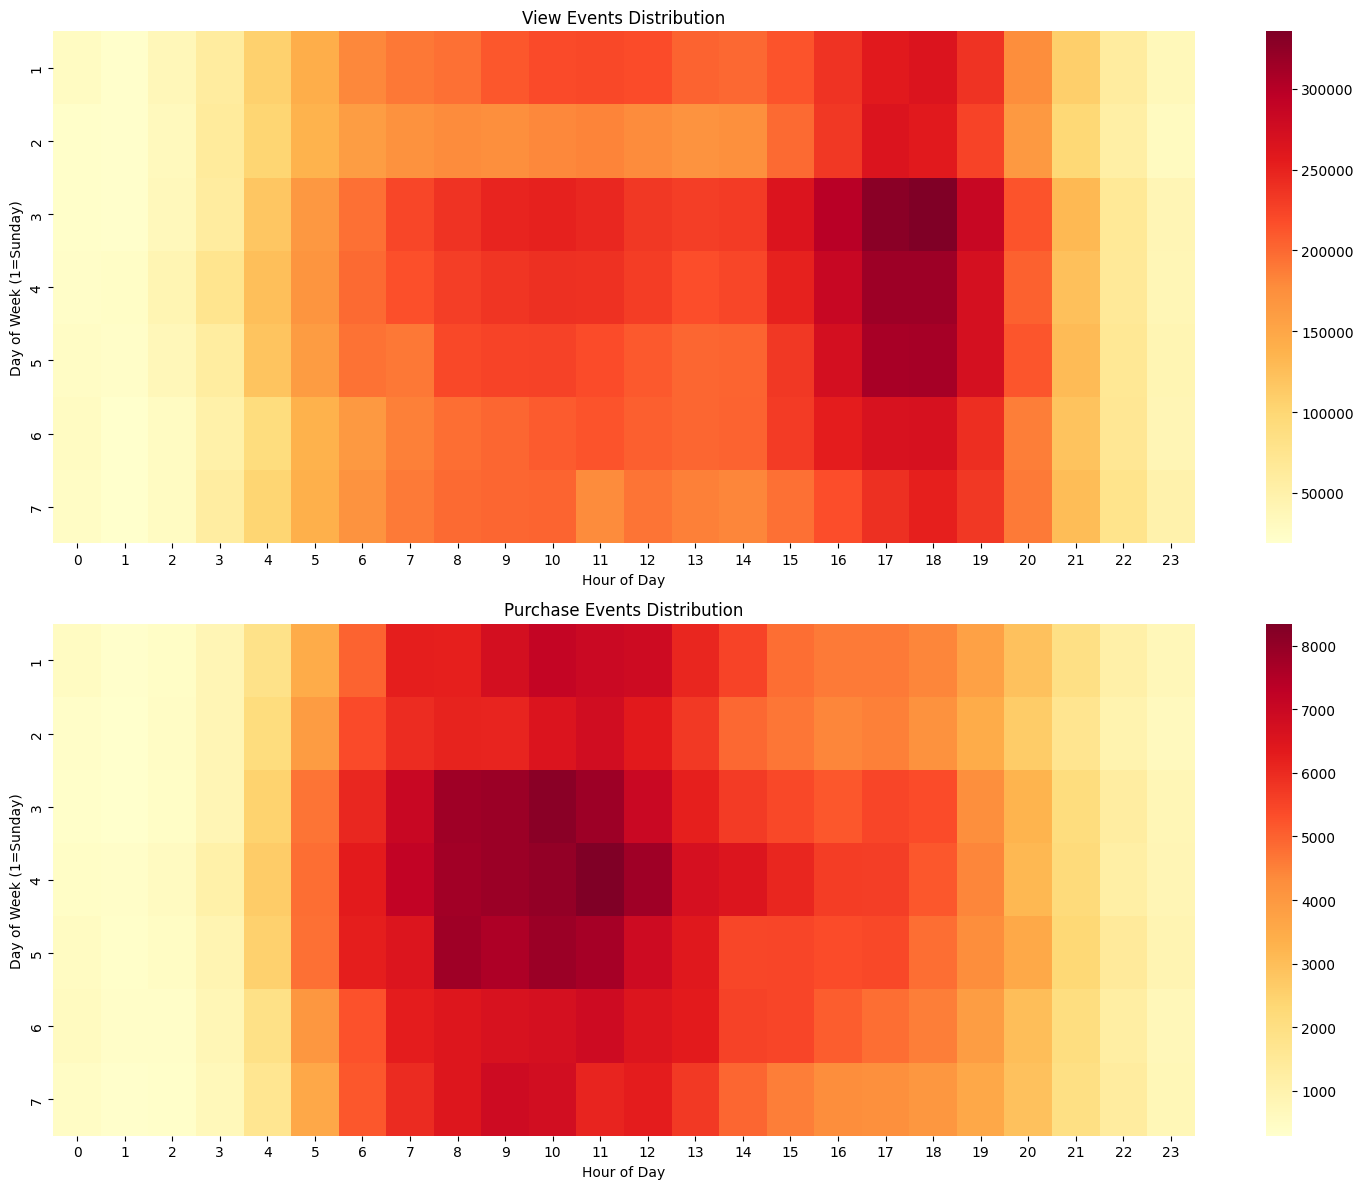

In [37]:
# Create subplots for comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot views heatmap
sns.heatmap(pivot_views, cmap='YlOrRd', ax=ax1)
ax1.set_title('View Events Distribution')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Day of Week (1=Sunday)')

# Plot purchases heatmap
sns.heatmap(pivot_purchases, cmap='YlOrRd', ax=ax2)
ax2.set_title('Purchase Events Distribution')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Day of Week (1=Sunday)')

plt.tight_layout()
plt.show()

Views peak during evening hours (17-19), with highest activity around 18:00, suggesting this is when users actively research products
Purchases concentrate during midday (10-14), indicating users tend to complete transactions during work/lunch hours
Clear separation between peak viewing and purchasing times shows a typical pattern: users research in evenings and buy next day

Implications for Recommendation System:
Evening hours (17-19): Focus on discovery-oriented recommendations to support research phase
Midday hours (10-14): Prioritize recommendations of previously viewed items, optimizing for conversion

User purchase prediction should consider 12-18 hour window between viewing and buying patterns

This time-based behavioral pattern suggests users follow a "research at night, buy during day" cycle, which should be incorporated into our recommendation strategy.

## Product Analysis

In [8]:
df = df.withColumn('category', F.split(F.col('category_code'), '\.').getItem(0))
df = df.withColumn('subcategory', F.split(F.col('category_code'), '\.').getItem(1))

In [9]:
df.show(30)

+-------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+-----------+--------------+
|         event_time|event_type|product_id|        category_id|       category_code|    brand|  price|  user_id|        user_session|   category|   subcategory|
+-------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+-----------+--------------+
|2019-10-01 02:09:43|      view|   4200541|2053013552351936731|appliances.enviro...| elenberg| 128.68|551258664|be0e1bd7-15c7-49d...| appliances|   environment|
|2019-10-01 03:41:04|      view|   4802036|2053013554658804075|electronics.audio...|    apple| 171.56|529402002|0304d27a-49a6-4a5...|electronics|         audio|
|2019-10-01 04:17:08|      view|   1307074|2053013558920217191|  computers.notebook|     acer| 772.19|554103839|f9270892-9b45-458...|  computers|      notebook|
|2019-10-01 04:19:42|      view|  

In [10]:
product_stats = df.groupBy("category").agg(
    F.count("*").alias("interaction_count"),
    F.countDistinct("user_id").alias("unique_users"),
    F.countDistinct("user_session").alias("unique_sessions"),
    F.mean("price").alias("avg_price"),
    F.sum(F.when(F.col("event_type") == "purchase", 1).otherwise(0)).alias("purchase_count"),
    F.sum(F.when(F.col("event_type") == "view", 1).otherwise(0)).alias("view_count")
)

In [11]:
product_stats_pd = product_stats.toPandas()

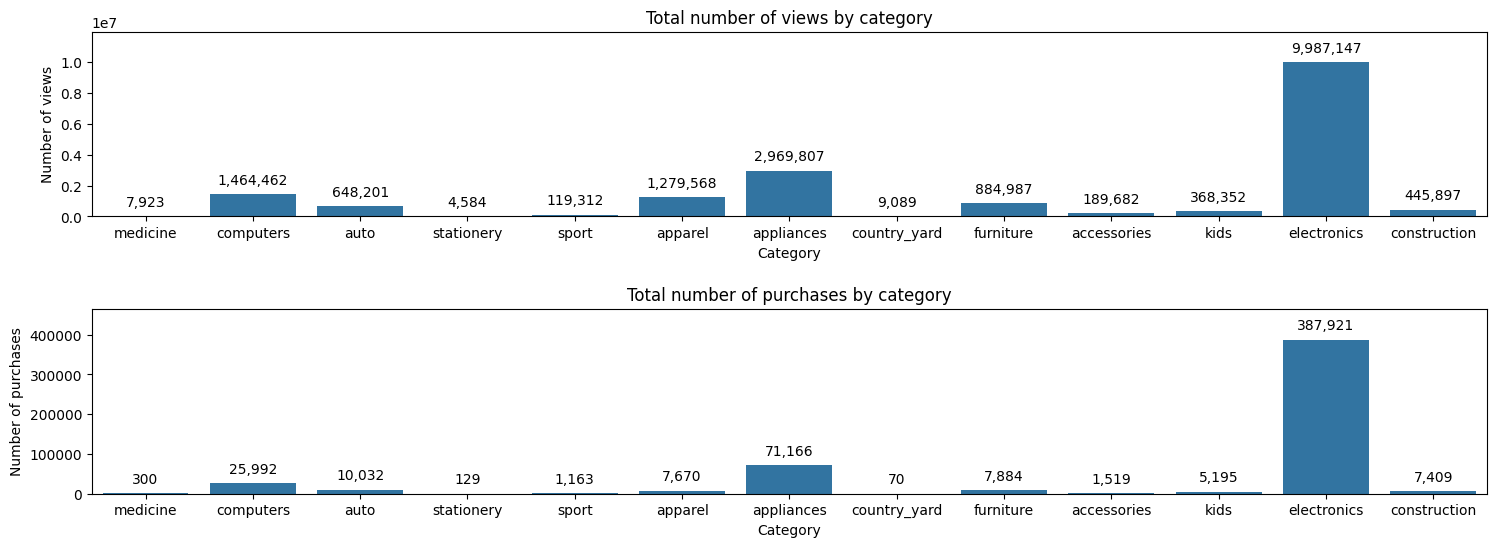

In [51]:
# Creating a plot that illustrates number of visits in each category during October
fig, axes = plt.subplots(2, 1, figsize=(18, 6))
plt.subplots_adjust(hspace=0.5)  # Add space between rows
axes = axes.flatten()

# First subplot for views
sns.barplot(x='category', y='view_count', data=product_stats_pd, ax=axes[0])
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

# Set titles and labels for first subplot
axes[0].set_title('Total number of views by category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Number of views')
axes[0].set_ylim(0, product_stats_pd['view_count'].max()*1.2)

# Second subplot for purchases
sns.barplot(x='category', y='purchase_count', data=product_stats_pd, ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

# Set titles and labels for second subplot
axes[1].set_title('Total number of purchases by category')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Number of purchases')
axes[1].set_ylim(0, product_stats_pd['purchase_count'].max()*1.2)

plt.show()

ValueError: Could not interpret value `subcategory` for `x`. An entry with this name does not appear in `data`.

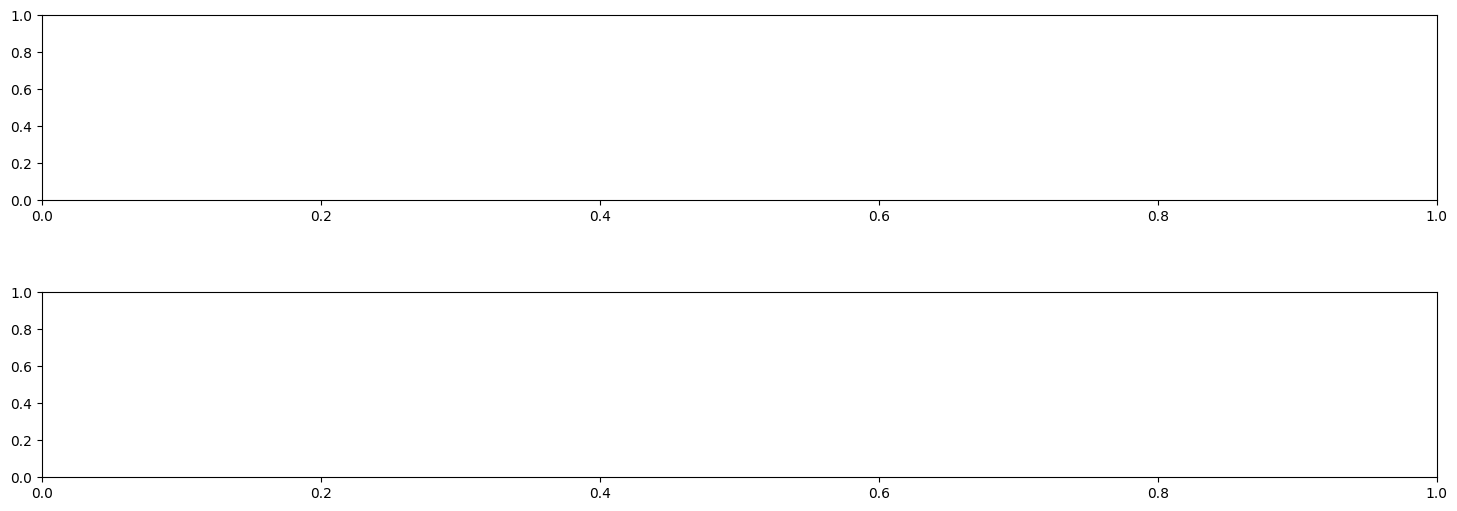

In [13]:
# Creating a plot that illustrates number of visits in each category during October
fig, axes = plt.subplots(2, 1, figsize=(18, 6))
plt.subplots_adjust(hspace=0.5)  # Add space between rows
axes = axes.flatten()

# First subplot for views
sns.barplot(x='subcategory', y='view_count', data=product_stats_pd, ax=axes[0])
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

# Set titles and labels for first subplot
axes[0].set_title('Total number of views by category')
axes[0].set_xlabel('Subcategory')
axes[0].set_ylabel('Number of views')
axes[0].set_ylim(0, product_stats_pd['view_count'].max()*1.2)

# Second subplot for purchases
sns.barplot(x='subcategory', y='purchase_count', data=product_stats_pd, ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

# Set titles and labels for second subplot
axes[1].set_title('Total number of purchases by category')
axes[1].set_xlabel('Subcategory')
axes[1].set_ylabel('Number of purchases')
axes[1].set_ylim(0, product_stats_pd['purchase_count'].max()*1.2)

plt.show()

__User-Product Interaction Analysis__

In [28]:
# Get interaction counts
interactions = df.groupBy("user_id", "product_id").count()

In [29]:
# Calculate sparsity
total_users = df.select("user_id").distinct().count()
total_products = df.select("product_id").distinct().count()
total_possible = total_users * total_products
total_actual = interactions.count()

sparsity = (1 - total_actual / total_possible) * 100
print(f"Interaction Matrix Sparsity: {sparsity:.2f}%")

Interaction Matrix Sparsity: 100.00%


In [30]:
# Get top users and products for sample visualization
top_users = df.groupBy("user_id").count() \
    .orderBy(F.desc("count")) \
    .limit(100) \
    .select("user_id")

sample_interactions = df.join(top_users, "user_id") \
    .groupBy("user_id", "product_id") \
    .count() \
    .toPandas()

In [31]:
# Create and visualize interaction matrix
interaction_matrix = sample_interactions.pivot(
    index='user_id', 
    columns='product_id', 
    values='count'
).fillna(0)

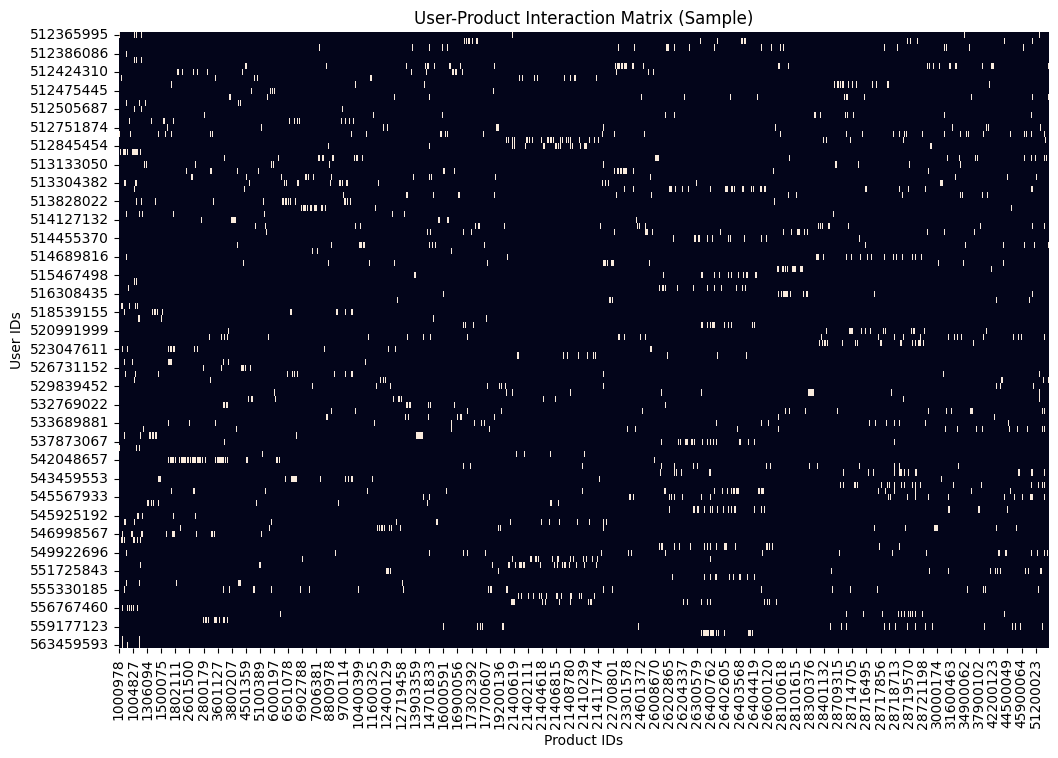

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(interaction_matrix.astype(bool), cbar=False)
plt.title('User-Product Interaction Matrix (Sample)')
plt.xlabel('Product IDs')
plt.ylabel('User IDs')
plt.show()

__Category and Price Analysis__

In [33]:
# Category analysis
category_analysis = df.groupBy("category_code").agg(
    F.countDistinct("product_id").alias("unique_products"),
    F.avg("price").alias("avg_price"),
    F.countDistinct("user_id").alias("unique_users"),
    F.sum(F.when(F.col("event_type") == "purchase", 1).otherwise(0)).alias("purchases")
)

In [34]:
# Calculate purchase rate
category_analysis = category_analysis.withColumn(
    "purchase_rate",
    F.round(F.col("purchases") / F.col("unique_users"), 4)
)

In [35]:
# Show top categories by purchase rate
category_analysis.orderBy(F.desc("purchase_rate")).show()


+--------------------+---------------+------------------+------------+---------+-------------+
|       category_code|unique_products|         avg_price|unique_users|purchases|purchase_rate|
+--------------------+---------------+------------------+------------+---------+-------------+
|electronics.smart...|           1285| 495.8578752117967|     1300236|   309120|       0.2377|
|electronics.audio...|           2134|100.08396394695083|      213964|    28062|       0.1312|
|appliances.enviro...|            611| 52.32012331535703|       19033|     2346|       0.1233|
|     appliances.iron|            439| 89.96824137761902|       29628|     3548|       0.1198|
|electronics.video.tv|            557|456.13012128077804|      170060|    20143|       0.1184|
|appliances.kitche...|            546| 333.8533985940731|      132034|    15057|        0.114|
|  computers.notebook|           1348| 735.0365963972059|      129214|    14393|       0.1114|
|appliances.enviro...|            434|110.46696034

In [36]:
# Price analysis by event type
price_stats = df.groupBy("event_type").agg(
    F.min("price").alias("min_price"),
    F.percentile_approx("price", 0.5).alias("median_price"),
    F.avg("price").alias("mean_price"),
    F.max("price").alias("max_price")
)

In [37]:
price_stats.show()

+----------+---------+------------+------------------+---------+
|event_type|min_price|median_price|        mean_price|max_price|
+----------+---------+------------+------------------+---------+
|  purchase|     0.77|       177.4|306.28599476701226|  2574.07|
|      view|      0.0|      159.59|  295.757775637087|  2574.07|
|      cart|      0.0|      203.09| 342.2952184337503|  2574.04|
+----------+---------+------------+------------------+---------+



In [14]:
product_info = df.groupBy('product_id').agg(
    F.first(F.col('brand'), ignorenulls=True).alias('most_common_brand'),
    F.first(F.col('category_code'), ignorenulls=True).alias('most_common_category')
)

In [16]:
product_info.count()

165647

In [19]:
nulled = product_info.filter(product_info.most_common_brand.isNull())

In [20]:
nulled.show(10)

+----------+-----------------+--------------------+
|product_id|most_common_brand|most_common_category|
+----------+-----------------+--------------------+
|   1201524|             NULL|  electronics.tablet|
|   1600405|             NULL|computers.periphe...|
|   1802031|             NULL|electronics.video.tv|
|   2402013|             NULL|appliances.kitche...|
|   2402611|             NULL|appliances.kitche...|
|   2402637|             NULL|appliances.kitche...|
|   2501239|             NULL|appliances.kitche...|
|   2600130|             NULL|                NULL|
|   2600153|             NULL|                NULL|
|   2600189|             NULL|                NULL|
+----------+-----------------+--------------------+
only showing top 10 rows



In [21]:
nulled.count()

42446

In [23]:
category_mapping = df.filter(F.col('category_code').isNull()) \
    .select('category_id') \
    .distinct()

In [24]:
category_mapping.count()

372

In [33]:
category_mapping = df.filter(df.category_code.isNull()) \
    .groupBy('category_id').agg(
        F.count('product_id').alias('product_count'),
        F.countDistinct('product_id').alias('unique_product_count')
    )
    

In [34]:
category_mapping.limit(20).show(20)

+-------------------+-------------+--------------------+
|        category_id|product_count|unique_product_count|
+-------------------+-------------+--------------------+
|2053013561554240247|         6131|                 158|
|2145727399348666855|         1283|                  14|
|2053013564968403895|        15172|                 431|
|2134905039313961849|         5365|                  81|
|2053013561747178243|         3077|                  82|
|2095518906859913319|         9098|                  59|
|2053013563139687243|        28190|                 109|
|2053013557737423389|          394|                  20|
|2053013555380224399|        27621|                  65|
|2053013562644759347|         5251|                 237|
|2070747673266226092|         7407|                 125|
|2053013558836331105|        12501|                 428|
|2080463777567867259|         1886|                 308|
|2053013557066334713|        36835|                 511|
|2095518917320508073|        11

In [25]:
new_df = df.withColumn('category_code',
    F.when(F.col('category_code').isNull(),
        F.concat(F.lit('custom_category_'), F.col('category_id').cast('string'))
    ).otherwise(F.col('category_code')))

In [39]:
new_df.select('*').where(df.category_id == 2053013561554240247).show()

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+--------+-----------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|category|subcategory|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+--------+-----------+
|2019-10-01 09:36:27|      view|  10600500|2053013561554240247|custom_category_2...|    NULL|  69.04|555530933|da621239-3e5a-435...|    NULL|       NULL|
|2019-10-01 06:11:08|      view|  10600294|2053013561554240247|custom_category_2...|kaemingk| 536.24|518639982|ef75180f-b624-4a3...|    NULL|       NULL|
|2019-10-01 16:18:38|      view|  10600455|2053013561554240247|custom_category_2...|    NULL|   78.3|552330003|8e9867c1-4d7e-40f...|    NULL|       NULL|
|2019-10-01 18:16:52|      view|  10600511|2053013561554240247|custom_catego